**Import all necessary libraries**

In [2]:

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import f1_score


**Load datasets from directory**

In [3]:
train_data = tf.keras.utils.image_dataset_from_directory(directory = r"/kaggle/input/malaria-cell/Malaria cells/cell_images",image_size = (50, 50), validation_split = 0.20, seed = 0, subset = 'training')
val_data = tf.keras.utils.image_dataset_from_directory(directory = r"/kaggle/input/malaria-cell/Malaria cells/cell_images", image_size = (50, 50), validation_split = 0.20, seed = 0, subset = 'validation')

Found 27558 files belonging to 2 classes.
Using 22047 files for training.
Found 27558 files belonging to 2 classes.
Using 5511 files for validation.


**Number of train and validation batches**

In [4]:
print(f'Number of train data batches = {train_data.cardinality()}')
print(f'Number of test data batches = {val_data.cardinality()}')

Number of train data batches = 689
Number of test data batches = 173


**Write function to get test data from validation data**

In [5]:

def split_data(data):
    N = data.cardinality().numpy()
    val_size = N//2
    test_size = N//2
    val_data = data.take(val_size)
    test_data = data.skip(val_size)
    return val_data, test_data
val_data, test_data = split_data(val_data)

**Get label names**

In [6]:
labels = train_data.class_names
print(labels)

['Parasitized', 'Uninfected']


**Write custom function to display sample images**

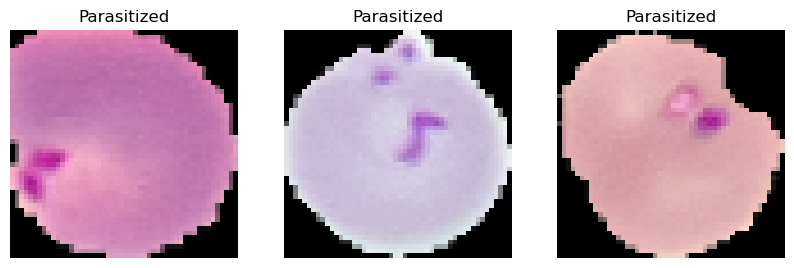

In [7]:
def show_sample(data, n_samples = 3):
    fig, ax = plt.subplots(1,n_samples, figsize = (10,10))
    for img_batch,label_batch in data.take(1):
        for i in range(n_samples):
            sample = tf.keras.utils.array_to_img(img_batch[i])
            ax[i].imshow(sample)
            ax[i].set_axis_off()
            ax[i].set_title(labels[label_batch[i].numpy()])
show_sample(test_data)

**Cache and Prefetch data pipeline to reduce I/O bottlenecks**

In [8]:
train_data = train_data.cache().prefetch(buffer_size = tf.data.AUTOTUNE)
val_data = val_data.cache().prefetch(buffer_size = tf.data.AUTOTUNE)
test_data = test_data.cache().prefetch(buffer_size = tf.data.AUTOTUNE)

**Custom Keras.Layer class to augment training data**

In [9]:
class augment(tf.keras.layers.Layer):
    def __init__(self):
        super(augment, self).__init__()
        self.flip = tf.keras.layers.RandomFlip('horizontal_and_vertical')
    def call(self, img, label):
        img = self.flip(img)
        return img, label

**Build custom model architecture**

In [17]:
input = tf.keras.layers.Input(shape = (50,50,3))
layer_0 = tf.keras.layers.Lambda(lambda x: tf.cast(x, tf.float32)/255)(input)
layer_1 = tf.keras.layers.Conv2D(128,2, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(layer_0)
layer_1a = tf.keras.layers.BatchNormalization()(layer_1)
layer_2 = tf.keras.layers.Conv2D(128,2, padding = 'valid', activation = 'relu', kernel_initializer = 'he_normal')(layer_1a)
layer_3 = tf.keras.layers.MaxPool2D(2)(layer_2)
layer_4 = tf.keras.layers.Conv2D(64,2, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(layer_3)
layer_4a = tf.keras.layers.BatchNormalization()(layer_4)
layer_5 = tf.keras.layers.Conv2D(64,2, padding = 'valid', activation = 'relu', kernel_initializer = 'he_normal')(layer_4a)
layer_6 = tf.keras.layers.MaxPool2D(2)(layer_5)
layer_6a = tf.keras.layers.Dropout(0.3)(layer_6)
layer_7 = tf.keras.layers.Conv2D(32,2, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(layer_6a)
layer_7a = tf.keras.layers.BatchNormalization()(layer_7)
layer_8 = tf.keras.layers.Conv2D(32,2, padding = 'valid', activation = 'relu', kernel_initializer = 'he_normal')(layer_7a)
layer_9 = tf.keras.layers.MaxPool2D(2)(layer_8)
layer_9a = tf.keras.layers.Dropout(0.3)(layer_9)
layer_10 = tf.keras.layers.Conv2D(16,2, padding = 'same', activation = 'relu', kernel_initializer = 'he_normal')(layer_9a)
layer_1a = tf.keras.layers.Dropout(0.5)(layer_1)
layer_11 = tf.keras.layers.Conv2D(16,2, padding = 'valid', activation = 'relu', kernel_initializer = 'he_normal')(layer_10)
layer_12 = tf.keras.layers.GlobalMaxPooling2D()(layer_11)
output = tf.keras.layers.Dense(1, activation = 'sigmoid', kernel_initializer = 'he_normal')(layer_12)
model = tf.keras.Model(input, output)

**Visualize model architecture**

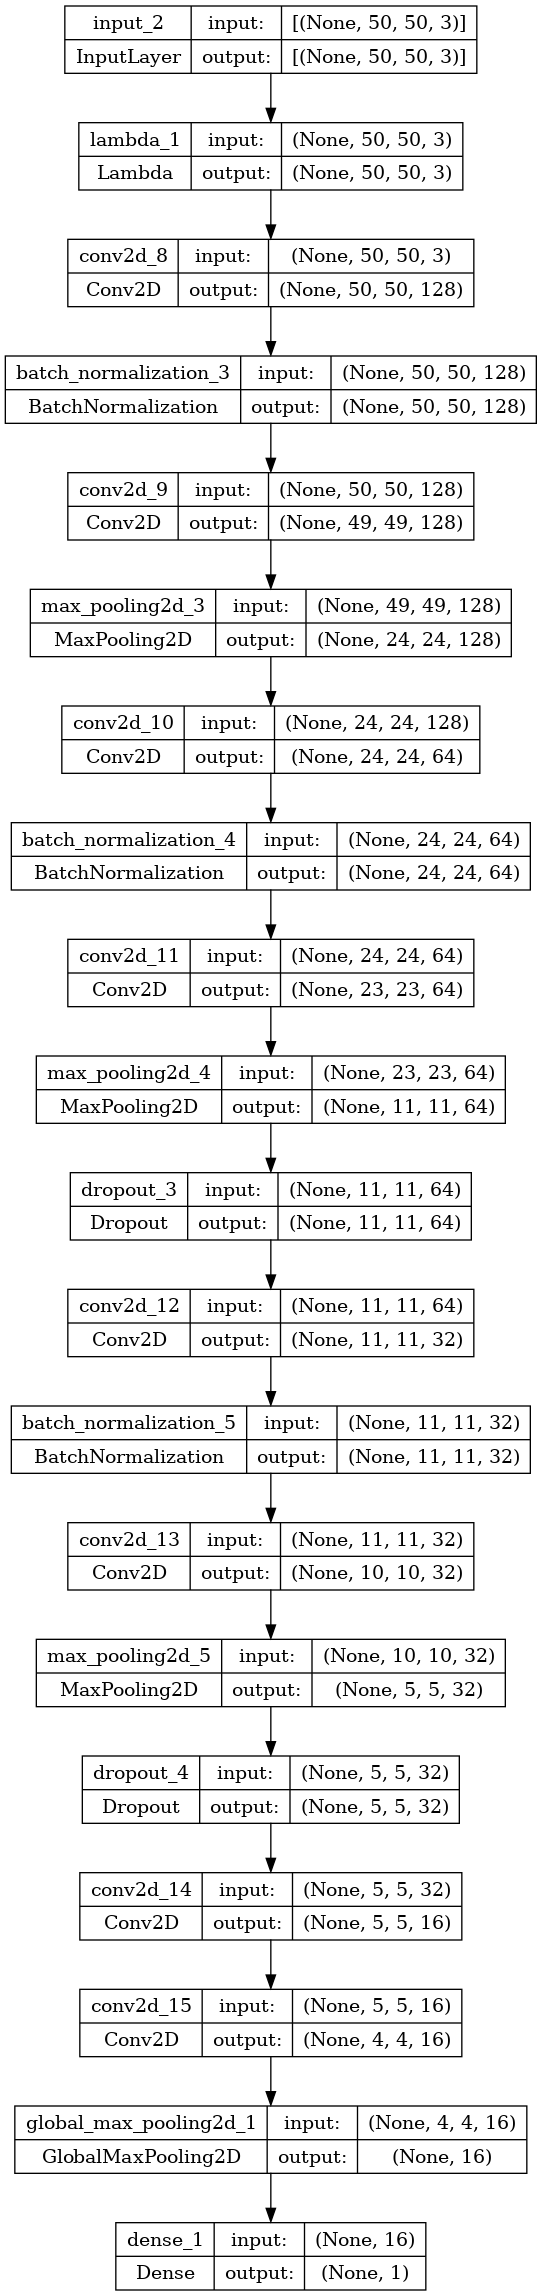

In [18]:
network_graph = tf.keras.utils.plot_model(model, show_shapes = True)
network_graph

**Compile model using adam as optimizer and binary crossentropy as loss fucntion**

In [19]:
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate = 0.005),loss = tf.keras.losses.BinaryCrossentropy(from_logits = False), metrics = ['binary_accuracy'])

**Define learning rate scheduler callback**

In [20]:

def scheduler(epoch, lr):
    if epoch <= 3:
        return lr
    elif epoch > 3 and epoch < 8:
        return 0.0005
    elif epoch >= 8 and epoch < 13:
        return 0.00005
    else:
        return lr * 0.001

LRS = tf.keras.callbacks.LearningRateScheduler(scheduler)

**Check model performance on test data before training**

In [21]:
test_labels = test_data.unbatch().map(lambda x,y: y)
test_labels = list(test_labels.as_numpy_iterator())
final_test_logits = model.predict(test_data.unbatch().map(lambda x,y: tf.expand_dims(x,0)))
final_test_preds = np.where(final_test_logits > 0.5, 1,0)

print(f'Initial f1 score is {(f1_score(final_test_preds, test_labels))}')

print(f'Initial accuracy is {model.evaluate(test_data)[1]}')

2759/2759 [==============================] - 6s 2ms/step
Initial f1 score is 0.6710019267822736
87/87 [==============================] - 1s 5ms/step - loss: 0.7873 - binary_accuracy: 0.5049
Initial accuracy is 0.5048930644989014


**Train the model**

In [23]:
history = model.fit(train_data, validation_data = val_data, epochs = 20, callbacks = [LRS]) 

Epoch 1/20
689/689 [==============================] - 12s 17ms/step - loss: 0.1937 - binary_accuracy: 0.9398 - val_loss: 0.1541 - val_binary_accuracy: 0.9593 - lr: 0.0050
Epoch 2/20
689/689 [==============================] - 12s 17ms/step - loss: 0.1605 - binary_accuracy: 0.9498 - val_loss: 0.1567 - val_binary_accuracy: 0.9506 - lr: 0.0050
Epoch 3/20
689/689 [==============================] - 12s 17ms/step - loss: 0.1523 - binary_accuracy: 0.9522 - val_loss: 0.1449 - val_binary_accuracy: 0.9520 - lr: 0.0050
Epoch 4/20
689/689 [==============================] - 12s 17ms/step - loss: 0.1450 - binary_accuracy: 0.9557 - val_loss: 0.1258 - val_binary_accuracy: 0.9593 - lr: 0.0050
Epoch 5/20
689/689 [==============================] - 12s 17ms/step - loss: 0.1244 - binary_accuracy: 0.9596 - val_loss: 0.1191 - val_binary_accuracy: 0.9618 - lr: 5.0000e-04
Epoch 6/20
689/689 [==============================] - 12s 17ms/step - loss: 0.1194 - binary_accuracy: 0.9604 - val_loss: 0.1181 - val_binary_

**Check model performance on test data after training**

In [24]:
test_labels = test_data.unbatch().map(lambda x,y: y)
test_labels = list(test_labels.as_numpy_iterator())
final_test_logits = model.predict(test_data.unbatch().map(lambda x,y: tf.expand_dims(x,0)))
final_test_preds = np.where(final_test_logits > 0.5, 1,0)

print(f'Final f1 score is {(f1_score(final_test_preds, test_labels))}')

print(f'Final accuracy is {model.evaluate(test_data)[1]}')

2759/2759 [==============================] - 6s 2ms/step
Final f1 score is 0.9623579545454545
87/87 [==============================] - 0s 5ms/step - loss: 0.1193 - binary_accuracy: 0.9616
Final accuracy is 0.9615802764892578


**Generate a dataframe of train and val data losses and accuracies at each epoch**

In [25]:
df = pd.DataFrame(data = history.history)

**PLot Train vs Validation loss and accuracy per epoch**

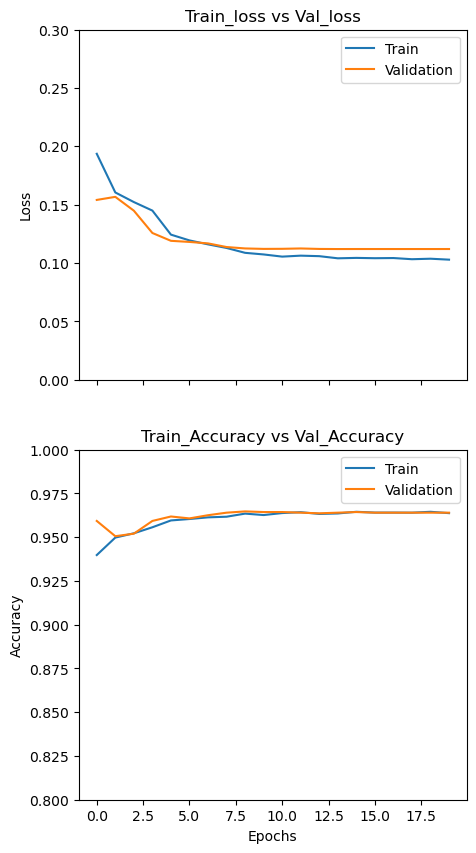

In [35]:
fig, ax = plt.subplots(2,1, sharex = True, figsize = (5,10))
ax[0].plot(df.index, df.loss, label = 'Train')
ax[0].plot(df.index, df.val_loss, label = 'Validation')
ax[0].set_ylim(0.0,0.3)
ax[0].set_title('Train_loss vs Val_loss')
ax[0].legend()
ax[0].set_ylabel('Loss')
ax[1].plot(df.index, df.binary_accuracy, label = 'Train')
ax[1].plot(df.index, df.val_binary_accuracy, label = 'Validation')
ax[1].set_ylim(0.8,1.0)
ax[1].set_title('Train_Accuracy vs Val_Accuracy')
ax[1].legend()
ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Epochs')
plt.show()